In [42]:
import matplotlib.pylab as plt
import numpy as np
from scipy import stats
import csv
from scipy import signal
import os.path 
from os import listdir
from os.path import isfile, join
from scipy.signal import savgol_filter
import copy
import pickle

In [2]:
#Funcion que hace una lista de los archivos de una carpeta
def ls(ruta = '.'):
    return [arch for arch in listdir(ruta) if isfile(join(ruta, arch))]
#correr ls('.')

In [13]:
lista_archivo = ls('.')

In [28]:
lista_archivo

['Analisis Cilindros.ipynb',
 'calibracion-0002.png',
 'calibracion-0003.png',
 'calibracion-1.png',
 'Cil2.csv',
 'Cil3.csv',
 'Cil4.csv']

##### Calibración

In [4]:
Cal =1.9484

##### Diccionario

In [7]:
lista_archivo
with open(lista_archivo[4], 'rt') as f:
        reader = csv.reader(f)
        info = list(reader)
        for row in reader:
            print(row)
info

[[' ', 'Area', 'Mean', 'Min', 'Max', 'XM', 'YM', 'Major', 'Minor', 'Angle'],
 ['1',
  '314',
  '255',
  '255',
  '255',
  '543.984',
  '81.904',
  '88.098',
  '4.538',
  '89.914'],
 ['2',
  '313',
  '255',
  '255',
  '255',
  '542.005',
  '81.871',
  '88.471',
  '4.505',
  '89.979'],
 ['3',
  '311',
  '255',
  '255',
  '255',
  '540.021',
  '82.092',
  '88.023',
  '4.499',
  '89.912'],
 ['4',
  '366',
  '255',
  '255',
  '255',
  '538.525',
  '82.792',
  '86.793',
  '5.369',
  '89.637'],
 ['5',
  '330',
  '255',
  '255',
  '255',
  '536.879',
  '82.542',
  '87.095',
  '4.824',
  '89.785'],
 ['6',
  '312',
  '255',
  '255',
  '255',
  '535.006',
  '81.997',
  '88.133',
  '4.507',
  '89.972'],
 ['7',
  '355',
  '255',
  '255',
  '255',
  '533.452',
  '82.348',
  '86.502',
  '5.225',
  '89.558'],
 ['8',
  '318',
  '255',
  '255',
  '255',
  '531.969',
  '81.890',
  '88.033',
  '4.599',
  '89.961'],
 ['9',
  '311',
  '255',
  '255',
  '255',
  '530.011',
  '82.117',
  '87.925',
  '4.504',


In [29]:
Ltot = {}
Masa = {}
Dmedio = {}

for i in range(2,5):
    Ltot[i]=40
    Dmedio[i]=1.9
# for i in info[1:]:
#     Lcil[int(i[0])] = float(i[1])
#     Ltot[int(i[0])] = float(i[2])
#     Dmedio[int(i[0])] = float(i[3])
#     Masa[int(i[0])] = float(i[4])

##### Funciones

In [8]:
def picosy(t,ym,nprc):
    #Cuentas para hallar la velocidad del Ym
    
    #resto recta
    gradient, intercept, r_value, p_value, std_err = stats.linregress(t,ym)
    nuevo = []
    for i,j in zip(t,ym):
        nuevo.append(j-gradient*i-intercept)
    #filtro
    nuevo2 = savgol_filter(nuevo, 51, 3)
    
    peakind = signal.find_peaks_cwt(nuevo2, np.arange(1,10),noise_perc=nprc)
    tpicos=[]
    ypicos=[]
    for j in peakind:
        tpicos.append(t[j])
        ypicos.append(ym[j])
    
    yperiod = []
    for i in range(len(tpicos)-1):
        yperiod.append(tpicos[i+1]-tpicos[i])
    return tpicos, ypicos, np.mean(yperiod)

In [9]:
def picosang(t,Ang,nprc):
    #filtro
    nuevo = savgol_filter(Ang, 51, 3)
    #busco picos
    peakind_Ang = signal.find_peaks_cwt(nuevo, np.arange(1,10),noise_perc=nprc)
    
    Ang_tpicos=[]
    Ang_picos=[]
    for j in peakind_Ang:
        Ang_tpicos.append(t[j])
        Ang_picos.append(Ang[j])

    Periodo_Ang = []
    for i in range(len(Ang_tpicos)-1):
        Periodo_Ang.append(Ang_tpicos[i+1]-Ang_tpicos[i])
    return Ang_tpicos, Ang_picos, np.mean(Periodo_Ang)

In [30]:
def analisis_de_cilindros(archivo,fps,Cal):
    
    with open(archivo, 'rt') as f:
        reader = csv.reader(f)
        data = list(reader)
        for row in reader:
            print(row)
 
    nro = float(archivo[3])
    
    tiempo = []
    Xm = []
    Ym = []
    ym = []
    Ang = []
    Angm = []
#     print(data[1][5]/Cal)
    for i in data[1:]:
        tiempo.append(float(i[0])/fps)
        Xm.append(float(i[5])/Cal)#-data[1][5]/Cal)
        Ym.append(float(i[6])/Cal)
        ym.append(-float(i[6])/Cal)
        Ang.append(float(i[9])-90)
        Angm.append(-(float(i[9])-90))
    
    #Calculo de la velocidad de sedimentacion del cilindro al descender verticalmente por la celda (vel de x centro de masa)          
    gradient, intercept, r_value, p_value, std_err = stats.linregress(tiempo,Xm)    

    tpicosM, ypicosM, Periodo_de_YM = picosy(tiempo,Ym,100) #Maximos
    tpicosm, ypicosm, Periodo_de_Ym= picosy(tiempo,ym,100) #Minimos
    ypicosm = -np.asarray(ypicosm)

    Ang_tpicosM, Ang_picosM, T_AngM = picosang(tiempo,Ang,100) #Maximos
    Ang_tpicosm, Ang_picosm, T_Angm = picosang(tiempo,Angm,100) #Minimos
    Ang_picosm = -np.asarray(Ang_picosm)
    
    Periodo_de_Y = (Periodo_de_YM+Periodo_de_Ym)/2
    T_Ang = (T_AngM+T_Angm)/2

    plt.figure(lista_archivo.index(archivo),figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(tiempo,Ym,label = 'Lcil = '+str(Ltot[nro])+', D = '+str(Dmedio[nro]))
    plt.plot(tpicosM,ypicosM,'r*')
    plt.plot(tpicosm,ypicosm,'m*')
    plt.grid(b=True, which='major')
    plt.subplot(1,3,2)
    plt.plot(tiempo,Ang,label = 'L = '+str(Ltot[nro])+', D = '+str(Dmedio[nro]))
    plt.plot(Ang_tpicosM,Ang_picosM,'r*')
    plt.plot(Ang_tpicosm,Ang_picosm,'m*')
    plt.grid(b=True, which='major')
    plt.subplot(1,3,3)
    plt.plot(tiempo,Xm,label = 'L = '+str(Ltot[nro])+', D = '+str(Dmedio[nro]))
    plt.grid(b=True, which='major')
    plt.legend()
    
    LaPapa = [nro,tiempo,Xm,Ym,Ang,tpicosM,ypicosM,tpicosm,ypicosm,Ang_tpicosM,Ang_picosM,Ang_tpicosm,Ang_picosm]
    #ERRORES
    #tiempo
#     errT = 1/fps
    
#     T4 = 0
#     T12 = 0
#     for i in yperiod:
#         T4 = i**(-4)+T4
#     for i in range(len(yperiod)-1):
#         T12 = -2/((yperiod[i]*yperiod[i+1])**2) + T12
#     errfy = (1/fps)*np.sqrt((T4+T12)/len(yperiod)) 
    
#     T4 = 0
#     T12 = 0
#     for i in Periodo_Ang:
#         T4 = i**(-4)+T4
#     for i in range(len(Periodo_Ang)-1):
#         T12 = -2/(Periodo_Ang[i]*Periodo_Ang[i+1]) + T12
#     errfa = (1/fps)*np.sqrt((T4+T12)/len(Periodo_Ang)) 
    
    return nro, gradient, Periodo_de_Y, T_Ang, LaPapa  
#     return L, D, gradient, std_err, Periodo_de_Y, errfy, T_Ang, errfa   

2.0 -30.947440384025743 0.9769539078156313 1.463927855711423
3.0 -30.280140365298973 1.4729458917835672 1.4131596526386105
4.0 -30.45161942827706 1.290008588605783 1.5856713426853708


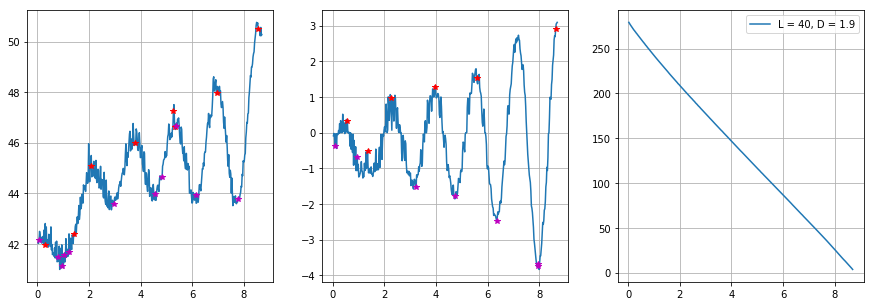

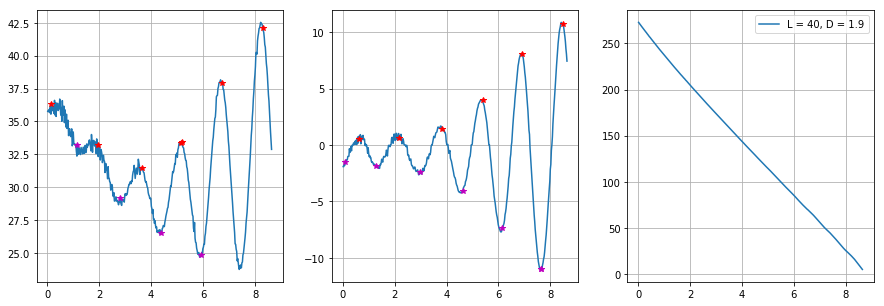

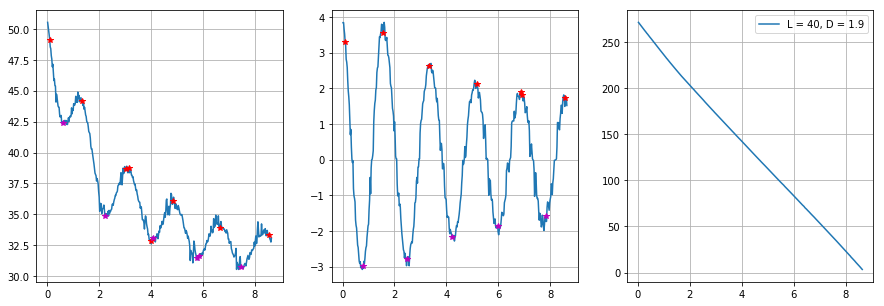

In [32]:
Discretos = []
MaximosY = {}
MinimosY = {}
MaximosA = {}
MinimosA = {}
tMaximosY = {}
tMinimosY = {}
tMaximosA = {}
tMinimosA = {}
Tiempo = {}
YCM = {}
XCM = {}
ANG = {}
VCM = {}
TY = {}
TA = {}
for i in range(3):
    nro, Vcm, Ty, Ta, dat = analisis_de_cilindros(lista_archivo[4+i],49.9,Cal)
    VCM[nro]=Vcm
    print(nro, Vcm, Ty, Ta)
    TY[nro]=Ty
    TA[nro]=Ta
    MaximosY[nro]=dat[6]
    tMaximosY[nro]=dat[5]
    MinimosY[nro]=dat[8]
    tMinimosY[nro]=dat[7]
    tMaximosA[nro] = dat[9]
    MaximosA[nro] = dat[10]
    tMinimosA[nro] = dat[11]
    MinimosA[nro] = dat[12]
    Tiempo[nro] = dat[1]
    YCM[nro] = dat[3]
    XCM[nro] = dat[2]
    ANG[nro] = dat[4]

##### Frecuencias

In [35]:
#Cil 2
j=2
f1=[]
f2=[]
for i in range(len(tMaximosA[j][2:5])-1):
    f1.append(tMaximosA[j][i+3]-tMaximosA[j][i+2])
for i in range(len(tMinimosA[j][2:6])-1):
    f2.append(tMinimosA[j][i+3]-tMinimosA[j][i+2])
TA[j]=np.mean([np.mean(f1),np.mean(f2)])
TA[j]

1.616566466265865

In [36]:
#Cil 3
j=3
f1=[]
for i in range(len(tMaximosA[j])-1):
    f1.append(tMaximosA[j][i+1]-tMaximosA[j][i])
f2=[]
for i in range(len(tMaximosA[j])-1):
    f2.append(tMaximosA[j][i+1]-tMaximosA[j][i])
TA[j]=np.mean([np.mean(f1),np.mean(f2)])
TA[j]

1.5671342685370742

In [37]:
#Cil 4
j=4
f1=[]
for i in range(len(tMaximosA[j][1:-2])-1):
    f1.append(tMaximosA[j][i+1+1]-tMaximosA[j][i+1])
f2=[]
for i in range(len(tMaximosA[j])-1):
    f2.append(tMaximosA[j][i+1]-tMaximosA[j][i])
TA[j]=np.mean([np.mean(f1),np.mean(f2)])
TA[j]

1.588176352705411

In [43]:

l = [1,2,3,4]
with open("test.txt", "wb") as fp:   #Pickling
    pickle.dump(l, fp)

with open("test.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

b

[1, 2, 3, 4]

In [41]:
output

<_io.TextIOWrapper name='file.txt' mode='w' encoding='cp1252'>